# Setup

## Fix import paths

The notebook lives in `<project_root>/notebooks/`, but imports should be relative to the project root.

In [1]:
# Fix up paths so we can import normally
import sys
import os
sys.path.insert(0, os.path.realpath('..'))

## Normal imports

In [2]:
import torch
import torchopt
from utils import dotdict
from autoencoders.sae_ensemble import FunctionalSAE
from autoencoders.sae import SAE
import numpy as np
from collections import deque
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from datetime import datetime

## Provide a path where the activations live

In [3]:
activation_files = [
    f'/workspace/sparse_coding/activation_data/sweep2/{i}.pt'
    for i in range(8)
]

## Set up config based on the activations in the first such file

In [36]:
cfg = dotdict({})

activations = torch.load(activation_files[0]).to(torch.float32).cuda()
cfg.activation_width = activations.shape[1]
cfg.dict_multiplier  = 4
cfg.l1_alpha         = 0.0003;
cfg.bias_l2_coef     = 0.0000;
cfg.dtype            = activations.dtype
cfg.device           = activations.device
cfg.batch_size       = 256
cfg.lr               = 0.0003
cfg.test_frac        = 0.0001
cfg.run_name         = datetime.utcnow().strftime('%Y-%m-%d-%H-%M-%SZ')
cfg.max_steps        = 10_000
cfg.dataset_name     = 'NeelNanda/pile-10k'
cfg.model_name       = "EleutherAI/pythia-70m-deduped"
cfg.layer            = 2
cfg.cache_name       = 'blocks.0.hook_resid_post'

for k, v in cfg.items():
    print(f'cfg.{k} = {cfg[k]}')

del activations

cfg.activation_width = 512
cfg.dict_multiplier = 4
cfg.l1_alpha = 0.0003
cfg.bias_l2_coef = 0.0
cfg.dtype = torch.float32
cfg.device = cuda:0
cfg.batch_size = 256
cfg.lr = 0.0003
cfg.test_frac = 0.0001
cfg.run_name = 2023-08-04-00-21-02Z
cfg.max_steps = 10000
cfg.dataset_name = NeelNanda/pile-10k
cfg.model_name = EleutherAI/pythia-70m-deduped
cfg.layer = 2
cfg.cache_name = blocks.0.hook_resid_post


# Training the autoencoders

## Define the autoencoder models

In [41]:
autoencoders = [
    SAE(
        cfg.activation_width,
        n_dict_components=cfg.activation_width*cfg.dict_multiplier,
        l1_coef=cfg.l1_alpha,
        bias_l2_coef=cfg.bias_l2_coef,
        activation="relu",
        t_type=cfg.dtype,
        bias=True
    ).to(cfg.device),
    SAE(
        cfg.activation_width,
        n_dict_components=cfg.activation_width*cfg.dict_multiplier*2,
        l1_coef=cfg.l1_alpha,
        bias_l2_coef=cfg.bias_l2_coef,
        activation="relu",
        t_type=cfg.dtype,
        bias=True
    ).to(cfg.device),
]
optimizers = [
    torch.optim.Adam(autoencoders[0].parameters(), lr=cfg.lr),
    torch.optim.Adam(autoencoders[1].parameters(), lr=cfg.lr),
]

## Split activations into test/train

We want to make sure that we use the same test/train split during every epoch

In [6]:
splits = []
test_dataset_parts = []
n_train = 0
for file_idx, activation_file in enumerate(activation_files):
    activations = torch.load(activation_file).to(torch.float32).cuda()
    # For each file index, store which sample indexes correspond to test vs train
    file_idx_col = torch.ones((len(activations), 1)) * file_idx
    act_idx_col  = torch.arange(len(activations)).reshape(len(activations),1)
    is_train_col = torch.rand((len(activations), 1)) >= cfg.test_frac
    splits.append(torch.hstack([
        file_idx_col.to(int),
        act_idx_col.to(int),
        is_train_col.to(int)
    ]))
    test_dataset_parts.append(activations[is_train_col[:,0] == False])
    n_train += len(activations[is_train_col[:,0]])
splits = torch.vstack(splits)
test_dataset = torch.vstack(test_dataset_parts)

## Actually do the training run

In [42]:
losses = {'loss': [], 'recon': [], 'l1': []}
step = 0
next_loss_calc = 100
n_epochs = 10
train_idx = 0

with tqdm(total=min(cfg.max_steps, (n_train * n_epochs) // cfg.batch_size)) as progress_bar:
    for epoch in range(n_epochs):
        for file_idx, activation_file in enumerate(activation_files):
            activations = torch.load(activation_file).to(torch.float32).cuda()
            train_act_idxs = splits[(splits[:,0] == file_idx)&(splits[:,2] == 1)][:,1]
            train_activations = activations[train_act_idxs]
            train_dataset = DataLoader(train_activations, batch_size=cfg.batch_size, shuffle=True)
            for _, train_batch in enumerate(train_dataset):
                for model, optimizer in zip(autoencoders, optimizers):
                    model.train_batch(train_batch, optimizer)
                    losses_at_step = {'loss':[], 'recon': [], 'l1': []}
                    if step >= next_loss_calc:
                        for _, test_batch in enumerate(test_dataset):
                            x_hat, c = model.forward(test_batch)
                            loss, l_reconstruction, l_l1 = model.loss(test_batch, x_hat, c)
                            losses_at_step['loss'].append(loss.detach().tolist())
                            losses_at_step['recon'].append(l_reconstruction.detach().tolist())
                            losses_at_step['l1'].append(l_l1.detach().tolist())
                        losses['loss'].append((step, sum(losses_at_step['loss']) / len(losses_at_step['loss'])))
                        losses['recon'].append((step, sum(losses_at_step['recon']) / len(losses_at_step['recon'])))
                        losses['l1'].append((step, sum(losses_at_step['l1']) / len(losses_at_step['l1'])))
                        next_loss_calc = int((next_loss_calc + 1) * 1.2)
                step += 1
                progress_bar.update(1)
                if step >= cfg.max_steps: break
            if step >= cfg.max_steps: break
        if step >= cfg.max_steps: break

losses['loss'] = np.array(losses['loss'])
losses['recon'] = np.array(losses['recon'])
losses['l1'] = np.array(losses['l1'])


100%|██████████| 10000/10000 [01:25<00:00, 116.32it/s]


# Verify the results look sane

In [43]:
d0 = autoencoders[0].decoder.weight.clone().detach()
d1 = autoencoders[1].decoder.weight.clone().detach()

d0 /= torch.linalg.norm(d0, axis=0)
d1 /= torch.linalg.norm(d1, axis=0)

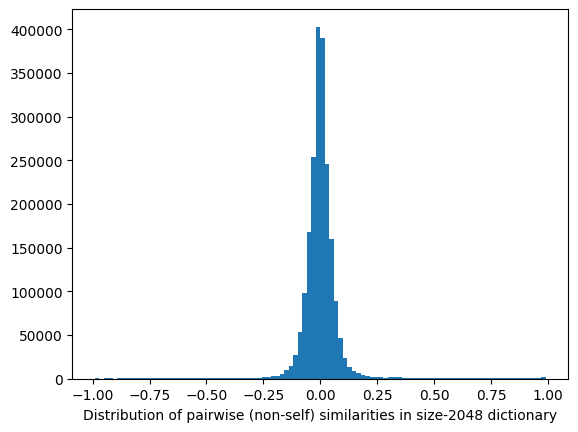

In [44]:
self_cosine_sim = (d0.T @ d0)

# Verify that dot product is in fact cosine sim here
assert 0.999 < self_cosine_sim.diag().min() < 1.001
assert 0.999 < self_cosine_sim.diag().max() < 1.001

# Plot the pairwise self-sim
pairwise_self_similarities = self_cosine_sim[np.triu_indices(d0.shape[1], k=1)].cpu()
hist = torch.histogram(pairwise_self_similarities, bins = 100, range=(-1.0, +1.0))
plt.xlabel(f"Distribution of pairwise (non-self) similarities in size-{d0.shape[1]} dictionary")
plt.hist((hist.bin_edges[:-1] + hist.bin_edges[1:]) / 2, hist.hist.shape[0], weights=hist.hist)
plt.show()

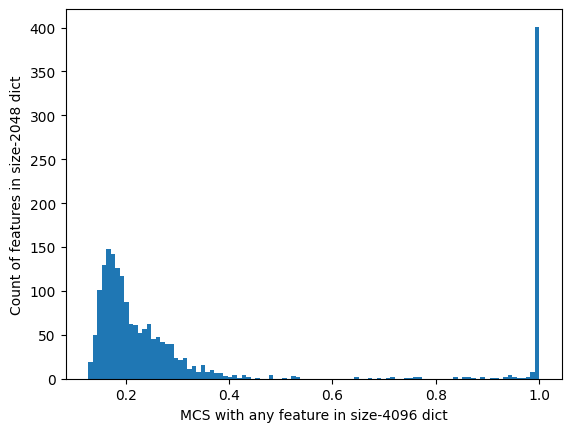

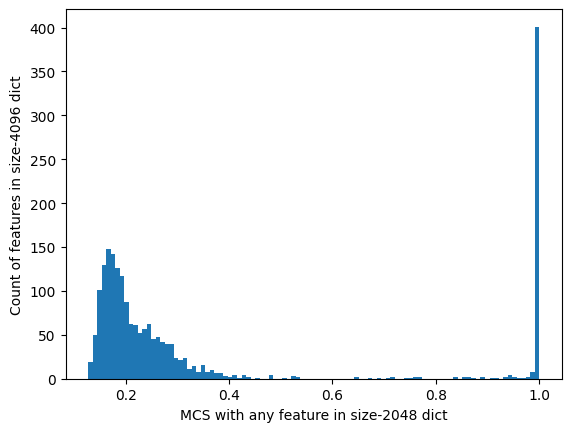

In [40]:
cos_sims_0 = np.zeros((d0.shape[1], d1.shape[1]))
cos_sims_1 = np.zeros((d1.shape[1], d0.shape[1]))
for idx, vector in enumerate(d0.T):
    cos_sims_0[idx] = torch.nn.functional.cosine_similarity(vector, d1.T, dim=1).cpu().numpy()
for idx, vector in enumerate(d1.T):
    cos_sims_1[idx] = torch.nn.functional.cosine_similarity(vector, d0.T, dim=1).cpu().numpy()
# Use the Hungarian algorithm to solve the assignment problem
# Retrieve the max cosine similarities and corresponding indices
mcs0 = cos_sims_0[tuple(linear_sum_assignment(1-cos_sims_0))]
mcs1 = cos_sims_1[tuple(linear_sum_assignment(1-cos_sims_1))]

plt.xlabel(f"MCS with any feature in size-{d1.shape[1]} dict")
plt.ylabel(f"Count of features in size-{d0.shape[1]} dict")
plt.hist(mcs0, bins=100)
plt.show()

plt.xlabel(f"MCS with any feature in size-{d0.shape[1]} dict")
plt.ylabel(f"Count of features in size-{d1.shape[1]} dict")
plt.hist(mcs1, bins=100)
plt.show()

In [45]:
scs = self_cosine_sim[:10,:10]
sort_orders = torch.argsort(scs**2).flip(dims=(1,))
torch.stack([scs[i,sort_order] for i, sort_order in enumerate(sort_orders)])

tensor([[ 1.0000e+00, -1.0085e-01, -8.7552e-02, -6.2061e-02,  3.3767e-02,
          1.8139e-02, -1.7735e-02,  1.3664e-02, -1.1374e-02,  3.1248e-03],
        [ 1.0000e+00,  7.5158e-02, -6.6050e-02, -6.5095e-02, -3.4108e-02,
          3.3767e-02, -2.6324e-02, -2.3446e-02,  1.3508e-03,  1.2112e-03],
        [ 1.0000e+00, -8.4252e-02,  6.6507e-02, -6.5620e-02,  3.2986e-02,
         -2.7764e-02, -2.6324e-02,  9.4102e-03,  3.1248e-03, -2.9156e-03],
        [ 1.0000e+00,  8.6542e-01, -1.0085e-01, -6.6050e-02, -6.3904e-02,
         -5.9134e-02,  4.9627e-02,  4.2101e-02, -3.8421e-02,  9.4102e-03],
        [ 1.0000e+00, -1.2775e-01, -8.4252e-02, -7.7424e-02, -6.3904e-02,
         -6.1758e-02, -1.9380e-02, -1.9231e-02,  1.3664e-02,  1.2112e-03],
        [ 1.0000e+00, -6.1758e-02, -5.9134e-02, -5.2883e-02, -1.7735e-02,
         -2.9156e-03,  2.3248e-03,  1.3508e-03,  9.7758e-04,  6.4439e-04],
        [ 1.0000e+00,  7.5158e-02,  7.1477e-02,  6.6507e-02, -4.3487e-02,
          4.2101e-02, -1.9231e-0

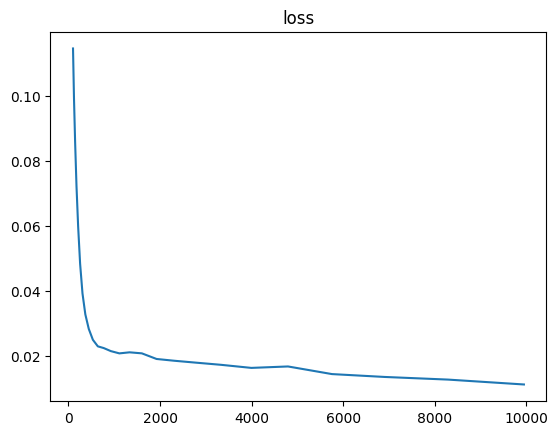

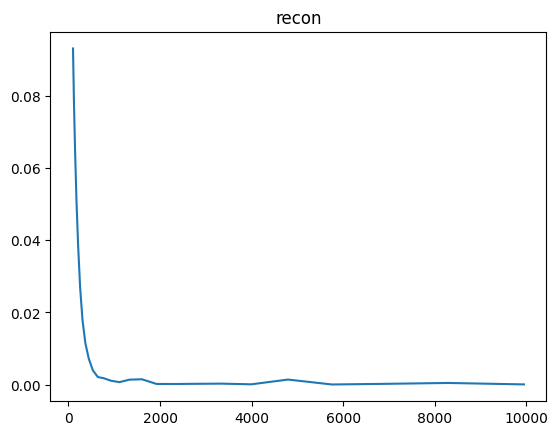

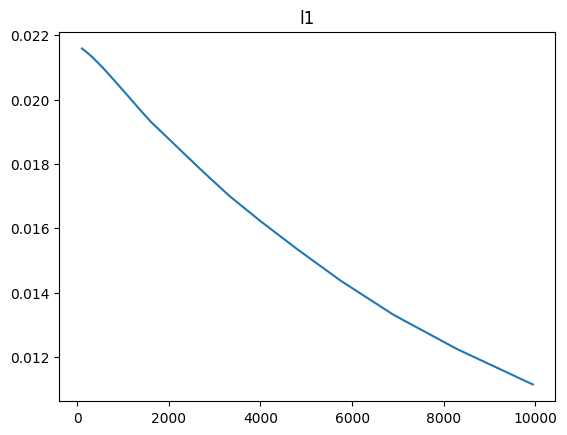

In [46]:
for k, loss in losses.items():
    plt.title(k)
    plt.plot(loss[:,0], loss[:,1])
    plt.show()

In [47]:
torch.save(autoencoders[0], f'/workspace/sparse_coding/outputs/manual.{cfg.run_name}.2048.pth')
torch.save(autoencoders[1], f'/workspace/sparse_coding/outputs/manual.{cfg.run_name}.4096.pth')

# Interpret the features

In [48]:
from transformer_lens import HookedTransformer
from datasets import Dataset, load_dataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange

In [49]:
model = HookedTransformer.from_pretrained(cfg.model_name)

Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer


In [50]:
dataset_name = "NeelNanda/pile-10k"
token_amount=64
dataset = load_dataset(cfg.dataset_name, split="train").map(
    lambda x: model.tokenizer(x['text']),
    batched=True,
).filter(
    lambda x: len(x['input_ids']) > token_amount
).map(
    lambda x: {'input_ids': x['input_ids'][:token_amount]}
)

Found cached dataset parquet (/root/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
Loading cached processed dataset at /root/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-ab69e87bb4a76316.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-e3421975a6277710.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-916ca1e390ec21f0.arrow


In [51]:
datapoints = dataset.num_rows
batch_size = 32
neuron_activations = torch.zeros((datapoints*token_amount, model.cfg.d_model))

dictionary_activationses = [
    torch.zeros((datapoints*token_amount, autoencoder.decoder.weight.shape[1]))
    for autoencoder in autoencoders
]

with torch.no_grad(), dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dl)):
        _, cache = model.run_with_cache(batch.to(cfg.device))
        batched_neuron_activations = rearrange(cache[cfg.cache_name], "b s n -> (b s) n" )
        neuron_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_neuron_activations.cpu()
        for autoencoder, dictionary_activations in zip(autoencoders, dictionary_activationses):
            reconstruction, batched_dictionary_activations = autoencoder(batched_neuron_activations)
            dictionary_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_dictionary_activations.cpu()

  0%|          | 0/301 [00:00<?, ?it/s]

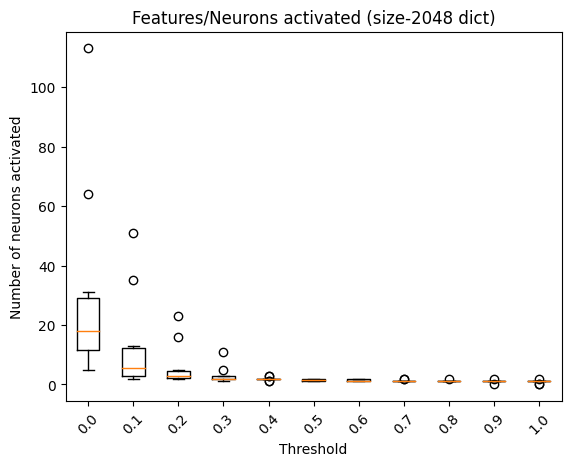

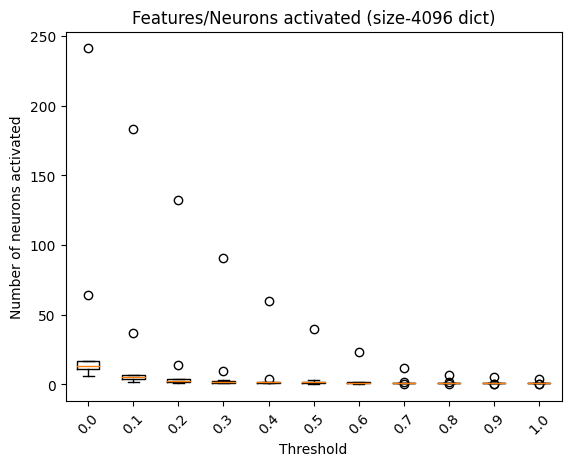

In [52]:
for dictionary_activations, mcs in zip(dictionary_activationses, [mcs0, mcs1]):
    max_indices = np.argsort(mcs)[::-1]
    thresholds = [round(0.1*x,1) for x in range(11)]
    all_activated_neurons = []
    for threshold in thresholds:
        current_activated_neurons = []
        for x in range(10):
            best_feature = max_indices[x]
            best_feature_activations = dictionary_activations[:, best_feature]
            # Sort the features by activation, get the indices
            nonzero_indices = torch.argsort(best_feature_activations, descending=True)
            sorted_indices = nonzero_indices[:10]
            t = (neuron_activations[sorted_indices, :] > threshold)
            # ( And across the first dim)
            t = t.all(dim=0)
            neurons_activated = t.sum()
            current_activated_neurons.append(neurons_activated)
            # print(f"Feature {x} is active for {t.sum()} neurons")
        all_activated_neurons.append(current_activated_neurons)
    # Plot boxplot w/ plotly
    
    plt.boxplot(all_activated_neurons, labels=thresholds)
    plt.xticks(rotation=45)
    plt.xlabel("Threshold")
    plt.ylabel("Number of neurons activated")
    plt.title(f"Features/Neurons activated (size-{dictionary_activations.shape[1]} dict)")
    # plt.ylim(0, 50)
    plt.show()

In [53]:
from circuitsvis.tokens import colored_tokens
from IPython.display import display, Markdown

In [54]:
batch.cuda()

display(Markdown(f'## Activation strength samples'))
for autoencoder, mcs in zip(autoencoders, [mcs0, mcs1]):
    display(Markdown(f'### Size-{autoencoder.decoder.weight.shape[1]} dictionary'))
    for feature_id in np.argsort(mcs0)[-10:]:
        _, cache = model.run_with_cache(batch)
        cache['blocks.2.hook_resid_post'].shape
        autoencoder_activations = autoencoders[0](cache['blocks.2.hook_resid_post'][0])[1]
        feature_activations = autoencoder_activations[:,feature_id]
        prompt_tokens = [model.tokenizer.decode([t]) for t in batch[0]]
        display(Markdown(f"#### Feature {feature_id}"))
        display(colored_tokens(prompt_tokens, feature_activations.tolist()))

## Activation strength samples

### Size-2048 dictionary

2023-08-04 00:38:31.500949: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Feature 605

#### Feature 1655

#### Feature 789

#### Feature 640

#### Feature 1563

#### Feature 1323

#### Feature 1440

#### Feature 1608

#### Feature 424

#### Feature 1845

### Size-4096 dictionary

#### Feature 605

#### Feature 1655

#### Feature 789

#### Feature 640

#### Feature 1563

#### Feature 1323

#### Feature 1440

#### Feature 1608

#### Feature 424

#### Feature 1845